In [64]:
suppressPackageStartupMessages({
    library(here) # All paths relative to the git directory
    library(ggplot2)
    library(patchwork)
    library(lubridate)
    library(dplyr)
    library(mgcv)
    library(tidymv)
    theme_set(theme_bw())
})
expit <- function(x) 1 / (1 + exp(-x))

In [16]:
jahn <- read.csv(here("data", "jahn_variants.csv"))
# Cleaning location names. 
jahn[, "locality"] <- strsplit(jahn[, "locality"], split = " - ") |> 
    sapply(function(x) x[2])
jahn$date <- ymd(jahn$date)

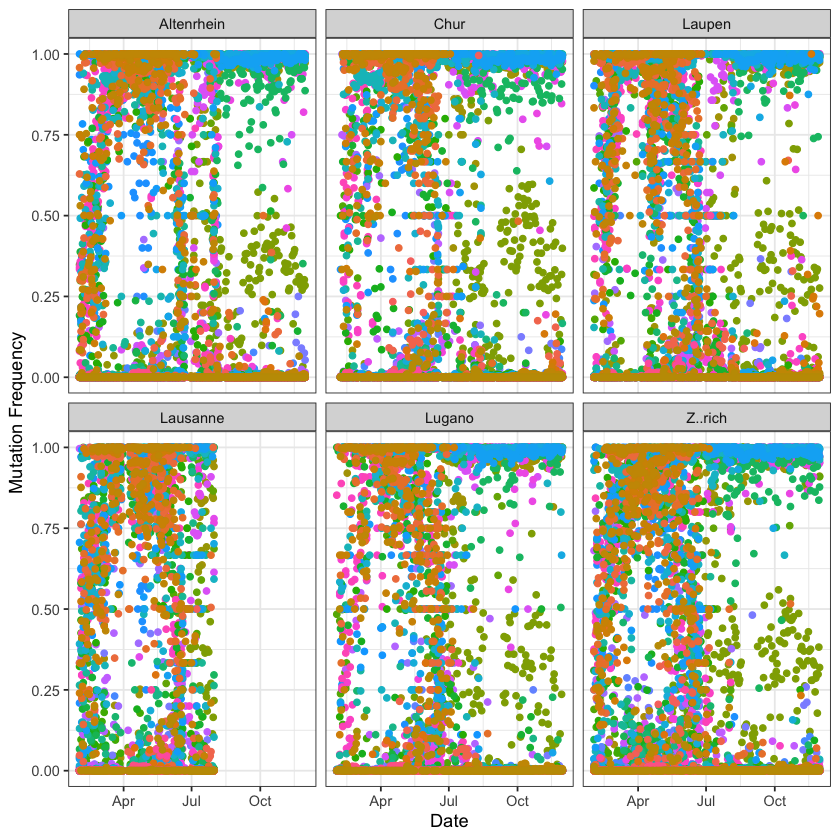

In [4]:
ggplot(jahn) +
    aes(x = ymd(date), y = frequency, colour = mutation) +
    geom_point() +
    facet_wrap(~ locality) +
    theme(legend.position = "none") +
    labs(x = "Date", y = "Mutation Frequency")

# Varying Coefficient Model

In [15]:
head(jahn)

,X,mutation,sample,date,locality,count,coverage,frequency,var_B.1.1.7,var_B.1.351,var_B.1.617.2,var_P.1
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,1,aa:E:P71L,ERR5922198,2021-02-13,Lausanne,1,3018,0.0003313453,0,1,0,0
2,2,aa:E:P71L,ERR5922199,2021-02-12,Lausanne,1,1177,0.0008496177,0,1,0,0
3,3,aa:E:P71L,ERR5922200,2021-02-10,Lausanne,2,4726,0.0004231909,0,1,0,0
4,4,aa:E:P71L,ERR5922201,2021-02-09,Lausanne,2,4032,0.0004960317,0,1,0,0
5,5,aa:E:P71L,ERR5922202,2021-02-07,Lausanne,1,4953,0.0002018978,0,1,0,0
6,6,aa:E:P71L,ERR5922203,2021-02-06,Lausanne,0,11,0.0000000000,0,1,0,0


In [30]:
jahn$dane <- as.numeric(ymd(jahn$date))
j2 <- jahn[jahn$locality == "Lugano", ]
j2 <- jahn %>%
    filter(locality == "Lugano") %>%
    rename(alpha = var_B.1.1.7, delta = var_B.1.617.2, 
        gamma = var_P.1, beta = var_B.1.351)
mygam <- gam(
    formula = cbind(count, coverage - count) ~ 
        s(dane, by = factor(alpha)) +
        s(dane, by = factor(beta)) +
        s(dane, by = factor(gamma)) +
        s(dane, by = factor(delta)),
    data = j2,
    family = binomial
    )

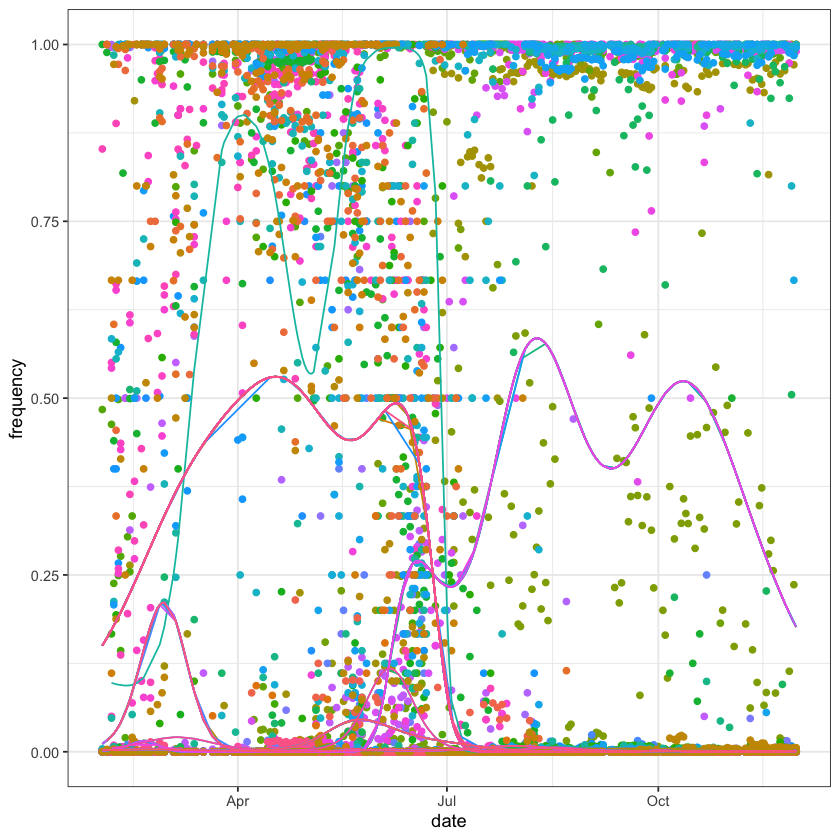

In [47]:
j2$preds <- predict(mygam)

ggplot(j2) + 
    geom_point(aes(x = date, y = frequency, colour = mutation)) + 
    geom_line(aes(x = date, y = 1/(1 + exp(-preds)), colour = mutation)) +
    theme(legend.position = "none")

List of 11
 $ x      : num [1:100] 18659 18662 18665 18668 18671 ...
 $ scale  : logi TRUE
 $ se     : num [1:100] 1.37 1.35 1.32 1.29 1.27 ...
 $ raw    : num [1:12885] 18955 18956 18957 18958 18959 ...
 $ xlab   : chr "dane"
 $ ylab   : chr "s(dane,1):factor(alpha)0"
 $ main   : NULL
 $ se.mult: num 2
 $ xlim   : num [1:2] 18659 18961
 $ fit    : num [1:100, 1] -28.2 -27.6 -27.1 -26.5 -26 ...
 $ plot.me: logi TRUE


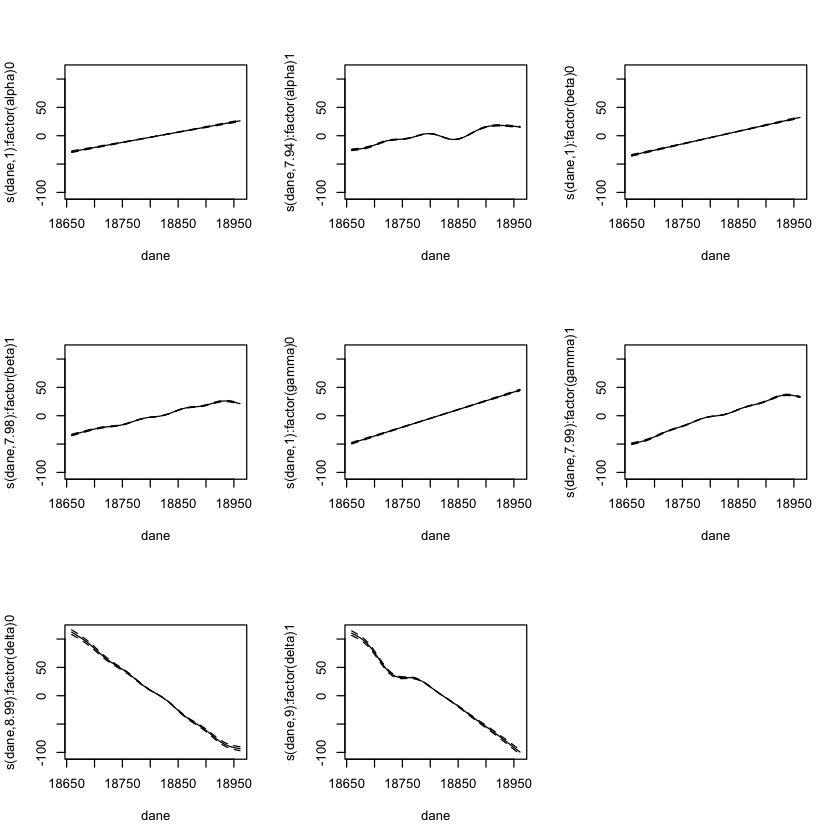

In [51]:
plot_obj <- plot(mygam, pages = 1)
str(plot_obj[[1]])

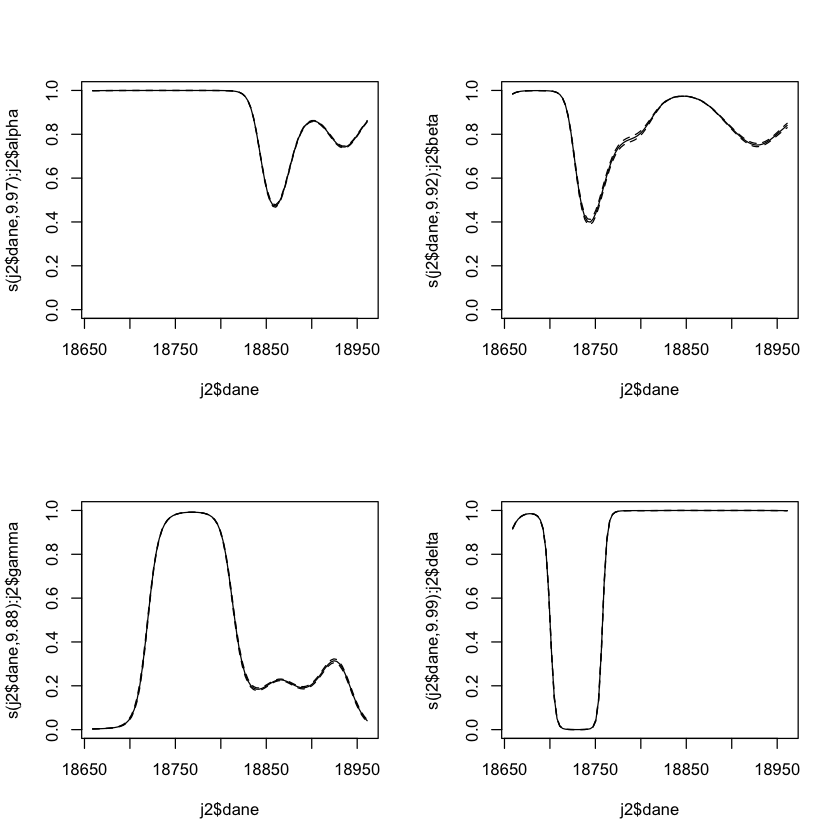

In [74]:
mygam2 <- gam(
    formula = cbind(count, coverage - count) ~ 
        s(j2$dane, by = j2$alpha) + s(j2$dane, by = j2$beta) + s(j2$dane, by = j2$gamma) + s(j2$dane, by = j2$delta),
    data = j2,
    family = binomial
    )
plot(mygam2, pages = 1, trans = expit, ylim = c(0,1))

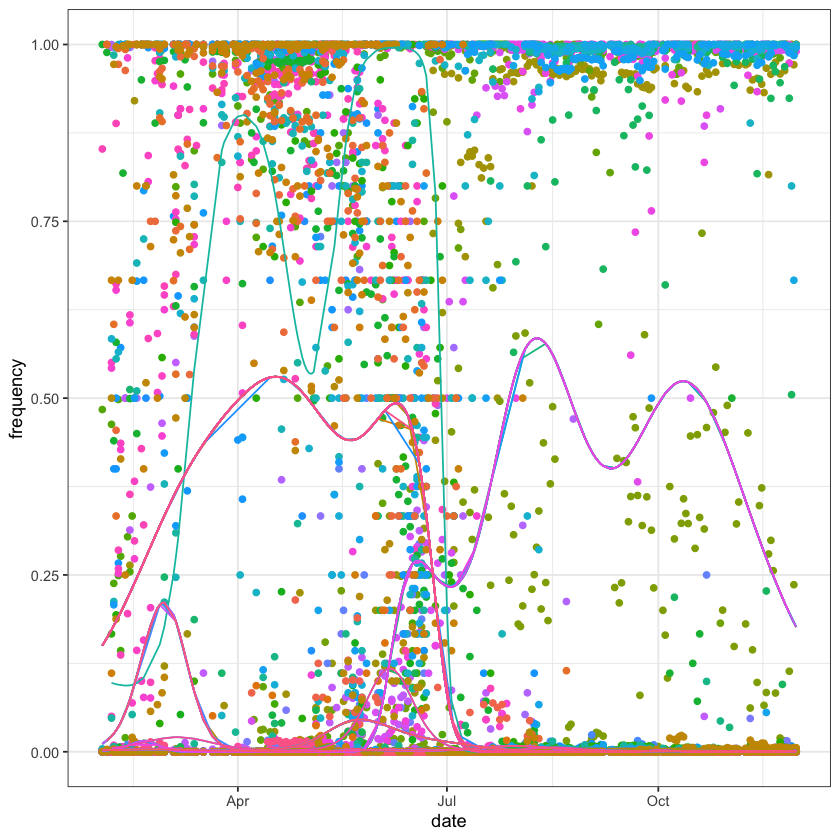

In [75]:
j2$preds2 <- predict(mygam)

ggplot(j2) + 
    geom_point(aes(x = date, y = frequency, colour = mutation)) + 
    geom_line(aes(x = date, y = 1/(1 + exp(-preds2)), colour = mutation)) +
    theme(legend.position = "none")